In [38]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from tensorflow import keras

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# 🔄 Replaced VGG19 with ResNet50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

import gc

print("Loading Libraries Done")


Loading Libraries Done


In [24]:
main_folder = "D:\\Neeru\\Python & DataScience\\Live projects\\RP_Project\\RP_dataset"

categories = os.listdir(main_folder)

# Optional: remove system file if it exists (useful on macOS)
# if ".DS_Store" in categories:
#     categories.remove(".DS_Store")

print(categories, len(categories))


['Normal', 'RP'] 2


In [25]:
import os
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import cv2

# 🔄 Updated to match ResNet50 input size
IMAGE_SIZE = (224, 224, 3)

def image_preprocessing_with_balanced_augmentation(main_folder, categories):
    img_lst = []
    labels = []

    image_counts = defaultdict(int)
    image_paths_by_class = defaultdict(list)

    # Step 1: Collect image paths
    for index, category in enumerate(categories):
        folder_path = os.path.join(main_folder, category)
        for image_name in os.listdir(folder_path):
            file_ext = image_name.split(".")[-1].lower()
            if file_ext in ["jpg", "jpeg", "png", "bmp"]:
                image_counts[index] += 1
                image_paths_by_class[index].append(os.path.join(folder_path, image_name))

    max_count = max(image_counts.values())

    # Step 2: Load images and augment only the minority class
    for index, category in enumerate(categories):
        print(f"Processing category: {category}")

        current_images = image_paths_by_class[index]
        total_original = len(current_images)
        augment_needed = max_count - total_original
        augmented_count = 0

        for image_path in tqdm(current_images):
            try:
                img = cv2.imread(image_path)
                img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Add original image
                img_lst.append(np.array(img))
                labels.append(index)

                # Augment only the minority class
                if augment_needed > 0 and augmented_count < augment_needed:
                    for aug_img in [cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE),
                                    cv2.flip(img, 1),
                                    cv2.flip(img, 0)]:
                        if augmented_count >= augment_needed:
                            break
                        img_lst.append(np.array(aug_img))
                        labels.append(index)
                        augmented_count += 1

            except Exception as e:
                print("Error with image:", image_path, e)

        if category == "RP":
            print(f"Augmented RP image count: {augmented_count}")

    images = np.array(img_lst, dtype=np.float16) / 255.0
    labels = np.array(labels, dtype=np.int8)
    return images, labels


In [26]:
images, labels = image_preprocessing_with_balanced_augmentation(main_folder, categories)
print("Balanced dataset shape:", images.shape, labels.shape)

Processing category: Normal


100%|██████████| 2676/2676 [02:15<00:00, 19.80it/s]


Processing category: RP


100%|██████████| 834/834 [01:08<00:00, 12.12it/s]


Augmented RP image count: 1842
Balanced dataset shape: (5352, 224, 224, 3) (5352,)


In [27]:
# First split into train+val and test
x_temp, x_test, y_temp, y_test = train_test_split(images, labels, test_size=0.1, random_state=6)

# Then split x_temp into train and val
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.1, random_state=6)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


x_train shape: (4334, 224, 224, 3)
y_train shape: (4334,)
x_val shape: (482, 224, 224, 3)
y_val shape: (482,)
x_test shape: (536, 224, 224, 3)
y_test shape: (536,)


In [28]:
# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)  # If you want to evaluate/test later


In [29]:
del labels
del images

In [30]:
EPOCHS = 10
BATCH_SIZE = 16

In [32]:
resnet = ResNet50(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)

In [33]:
# Do not train the pre-trained layers of ResNet50
for layer in resnet.layers:
    layer.trainable = False

In [35]:
TOTAL_CATEGORIES = len(categories)

x = GlobalAveragePooling2D()(resnet.output)  # Better for ResNet
x = Dense(256, activation='relu')(x)         # Optional dense layer
x = Dropout(0.5)(x)                           # Optional dropout to prevent overfitting
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)

resnet_model = Model(inputs=resnet.input, outputs=prediction)
resnet_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [36]:
resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # changed from binary_crossentropy
    metrics=['accuracy']
)


In [ ]:
#Early stopping to avoid overfitting of model
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    patience=3, 
    restore_best_weights=True,
    verbose=1
)

In [40]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.applications import ResNet50

# Load ResNet50 model pre-trained on ImageNet (without the top layer)
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model to avoid retraining them
for layer in resnet_base.layers:
    layer.trainable = False

# Add custom top layers
x = resnet_base.output
x = GlobalAveragePooling2D()(x)  # Pooling layer
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dense(2, activation='softmax')(x)  # Output layer with 2 units for multiclass

# Define the final model
resnet_model = Model(inputs=resnet_base.input, outputs=x)

# Compile the model
resnet_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = resnet_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    shuffle=True
)


Epoch 1/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 220s 788ms/step - accuracy: 0.5425 - loss: 0.7831 - val_accuracy: 0.6328 - val_loss: 0.5572
Epoch 2/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 223s 825ms/step - accuracy: 0.7321 - loss: 0.5399 - val_accuracy: 0.8589 - val_loss: 0.3981
Epoch 3/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 240s 885ms/step - accuracy: 0.7663 - loss: 0.4756 - val_accuracy: 0.7448 - val_loss: 0.4595
Epoch 4/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 235s 866ms/step - accuracy: 0.8024 - loss: 0.4284 - val_accuracy: 0.7988 - val_loss: 0.3896
Epoch 5/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 233s 861ms/step - accuracy: 0.8208 - loss: 0.3900 - val_accuracy: 0.8983 - val_loss: 0.3023
Epoch 6/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 235s 865ms/step - accuracy: 0.8241 - loss: 0.3927 - val_accuracy: 0.9066 - val_loss: 0.2509
Epoch 7/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 235s 867ms/step - accuracy: 0.8745 - loss: 0.2978 - val_accuracy: 0.9170 - val_loss: 0.2449
Epoch 8/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 228s 842ms/step - accuracy: 0.8844 -

In [41]:
import tensorflow as tf

# Clear any previous model from memory
tf.keras.backend.clear_session()

# Evaluate the ResNet model
loss, acc = resnet_model.evaluate(x_test, y_test, batch_size=32)
print("ResNet Loss:", loss)
print("ResNet Accuracy:", acc * 100, "%")


17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9049 - loss: 0.2399
ResNet Loss: 0.25548622012138367
ResNet Accuracy: 89.92537260055542 %


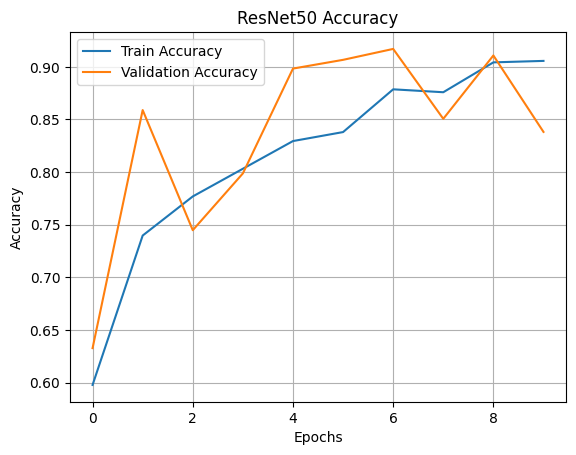

In [42]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("ResNet50 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


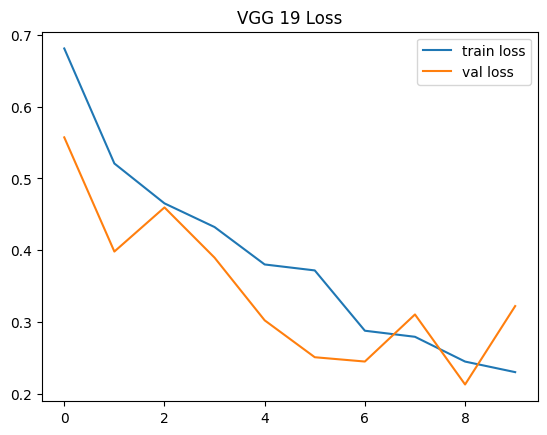

In [43]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("VGG 19 Loss")
plt.legend()
plt.show()

In [45]:
import numpy as np

# Predict using the model
y_pred = resnet_model.predict(x_test)

# If using softmax output (2 classes), convert predictions to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# If labels are one-hot encoded, convert them to class indices
y_test_flat = np.argmax(y_test, axis=1)

# Print shapes
print(f"y_test_flat shape: {y_test_flat.shape}")
print(f"y_pred shape: {y_pred_classes.shape}")


17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step
y_test_flat shape: (536,)
y_pred shape: (536,)


In [46]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 1. Predict raw output
y_pred_raw = resnet_model.predict(x_test)

# 2. If shape is (num_samples, 2), convert to predicted class using argmax
if y_pred_raw.shape[1] == 2:
    y_pred = np.argmax(y_pred_raw, axis=1)
else:
    # Binary case: shape is (num_samples, 1) – use threshold
    y_pred = (y_pred_raw > 0.5).astype("int32").flatten()

# 3. Convert y_test if it's one-hot encoded
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test_flat = np.argmax(y_test, axis=1)
else:
    y_test_flat = y_test.flatten()

# 4. Confirm shapes now match
print(f"y_test_flat shape: {y_test_flat.shape}, y_pred shape: {y_pred.shape}")

# 5. Evaluation
print("Classification Report:")
print(classification_report(y_test_flat, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test_flat, y_pred))


17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step
y_test_flat shape: (536,), y_pred shape: (536,)
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89       268
           1       0.83      1.00      0.91       268

    accuracy                           0.90       536
   macro avg       0.91      0.90      0.90       536
weighted avg       0.91      0.90      0.90       536

Confusion Matrix:
[[215  53]
 [  1 267]]


In [48]:
# Save the ResNet model
resnet_model.save("RP_detection_model.h5", save_format="h5")
